<a href="https://colab.research.google.com/github/hugosimasalmeida/trading/blob/main/Copy_of_trading_bot_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from https://github.com/hugosimasalmeida/FinRL/blob/master/notebooks/old/DRL_multiple_stock_trading.ipynb

import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas','numpy', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install git+https://github.com/quantopian/pyfolio

     |████████████████████████████████| 6.3MB 4.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=993703399b571308dc9ae8a67a47932fb8dfda586f4f7c21caadebe235d53f1e
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 245kB 4.0MB/s 
     |████████████████████████████████| 1.4MB 23.4MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp37-cp37m-linux_x86_64.whl size=2065223 sha256=ef9d4c4fe8aeb3d31334c89a18deef1b28c8bbb6950a7a1b74b85ea895be0aad
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py
     |████████████████████████████████| 110.5MB 100kB/s 
     |████████████████████████████████| 512kB 45.2MB/s 
     |████████████

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-dyt65moq
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-dyt65moq
     |████████████████████████████████| 61kB 2.5MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-cp37-none-any.whl size=75776 sha256=25556fec7077e25607843beefbfc98cc748fd200d590dd8b97da030876c775b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-knd82zjd/wheels/62/7d/a7/3e462442ba7d63c35414176627c886340521dc3dbc0893ce9f
  Created wheel for empyrical: filename=empyrical-0.5.5-cp37-none-any.whl size=39780 sha256=53367497f446f2bc7430ba8c9246652b94d916f0cc2111c82ac2200740e785b1
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

import yfinance as yf
from stockstats import StockDataFrame as Sdf
import pyfolio

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3, TRPO
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [2]:
# Dow 30 constituents at 2019/01/01
dow_30_ticker = ['AAPL','MSFT','JPM','V','RTX','PG','GS','NKE','DIS','AXP',
                  'HD','INTC','WMT','IBM','MRK','UNH','KO','CAT','TRV','JNJ',
                  'CVX','MCD','VZ','CSCO','XOM','BA','MMM','PFE','WBA','DD']

In [3]:
# Download and save the data in a pandas DataFrame:
dow_30 = pd.DataFrame()
for tic in dow_30_ticker:
    data_df = yf.download(tic, start="2009-01-01", end="2021-06-15")
    data_df['tic'] = tic
    dow_30=dow_30.append(data_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
dow_30.shape

(93990, 7)

In [6]:
dow_30.head()

,Open,High,Low,Close,Adj Close,Volume,tic
Date,,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.787006,746015200,AAPL
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.904629,1181608400,AAPL
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.856720,1289310400,AAPL
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.794991,753048800,AAPL
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.846893,673500800,AAPL


In [7]:
# reset the index, we want to use numbers instead of dates
dow_30=dow_30.reset_index()

In [8]:
# convert the column names to standardized names
dow_30.columns = ['datadate','open','high','low','close','adjcp','volume','tic']


In [9]:
# convert date to string format, easy to filter
dow_30['datadate']=dow_30.datadate.apply(lambda x: x.strftime('%Y-%m-%d'))

In [10]:
dow_30.head()

,datadate,open,high,low,close,adjcp,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.787006,746015200,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.904629,1181608400,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.856720,1289310400,AAPL
3,2009-01-07,3.278929,3.303571,3.223571,3.250357,2.794991,753048800,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.846893,673500800,AAPL


In [11]:
dow_30.shape

(93990, 8)

In [12]:
# check missing data 
dow_30.isnull().values.any()

False

In [14]:
dow_30=dow_30.dropna()

In [15]:
dow_30.tic.value_counts()

GS      3133
MCD     3133
PG      3133
WMT     3133
UNH     3133
INTC    3133
CVX     3133
IBM     3133
DIS     3133
JPM     3133
HD      3133
MSFT    3133
V       3133
AAPL    3133
PFE     3133
VZ      3133
KO      3133
RTX     3133
CSCO    3133
XOM     3133
NKE     3133
TRV     3133
WBA     3133
BA      3133
AXP     3133
DD      3133
MRK     3133
JNJ     3133
MMM     3133
CAT     3133
Name: tic, dtype: int64

In [16]:
# check missing data 
dow_30.isnull().values.any()

False

In [17]:
def add_technical_indicator(df):
        """
        calcualte technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        stock = Sdf.retype(df.copy())
        stock['close'] = stock['adjcp']
        unique_ticker = stock.tic.unique()

        macd = pd.DataFrame()
        rsi = pd.DataFrame()

        #temp = stock[stock.tic == unique_ticker[0]]['macd']
        for i in range(len(unique_ticker)):
            ## macd
            temp_macd = stock[stock.tic == unique_ticker[i]]['macd']
            temp_macd = pd.DataFrame(temp_macd)
            macd = macd.append(temp_macd, ignore_index=True)
            ## rsi
            temp_rsi = stock[stock.tic == unique_ticker[i]]['rsi_30']
            temp_rsi = pd.DataFrame(temp_rsi)
            rsi = rsi.append(temp_rsi, ignore_index=True)

        df['macd'] = macd
        df['rsi'] = rsi
        return df

In [18]:
dow_30 = add_technical_indicator(dow_30)

In [19]:
dow_30.shape

(93990, 10)

In [20]:
dow_30.head()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.787006,746015200,AAPL,0.000000,NaN
1,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.904629,1181608400,AAPL,0.002639,100.000000
2,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.856720,1289310400,AAPL,0.001877,70.355617
3,2009-01-07,3.278929,3.303571,3.223571,3.250357,2.794991,753048800,AAPL,-0.000744,50.429326
4,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.846893,673500800,AAPL,-0.000088,60.227078


In [21]:
dow_30.tail()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi
93985,2021-06-08,84.470001,85.330002,83.620003,84.849998,84.849998,2379500,DD,1.506035,59.015221
93986,2021-06-09,84.529999,84.870003,83.870003,84.169998,84.169998,1492900,DD,1.367346,57.517169
93987,2021-06-10,84.889999,85.050003,82.779999,82.809998,82.809998,2024600,DD,1.134615,54.647157
93988,2021-06-11,83.349998,84.199997,82.250000,82.529999,82.529999,3202900,DD,0.917009,54.072507
93989,2021-06-14,82.400002,82.779999,80.980003,81.550003,81.550003,2700300,DD,0.657893,52.089268


In [22]:
# check missing data 
dow_30.isnull().values.any()

True

In [23]:
dow_30.isna().any()

datadate    False
open        False
high        False
low         False
close       False
adjcp       False
volume      False
tic         False
macd        False
rsi          True
dtype: bool

In [24]:
# fill missing data with forward filling and backward filling
dow_30=dow_30.fillna(method='ffill')
dow_30=dow_30.fillna(method='bfill')

In [25]:
# check missing data 
dow_30.isnull().values.any()

False

In [26]:
dow_30.tail()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi
93985,2021-06-08,84.470001,85.330002,83.620003,84.849998,84.849998,2379500,DD,1.506035,59.015221
93986,2021-06-09,84.529999,84.870003,83.870003,84.169998,84.169998,1492900,DD,1.367346,57.517169
93987,2021-06-10,84.889999,85.050003,82.779999,82.809998,82.809998,2024600,DD,1.134615,54.647157
93988,2021-06-11,83.349998,84.199997,82.250000,82.529999,82.529999,3202900,DD,0.917009,54.072507
93989,2021-06-14,82.400002,82.779999,80.980003,81.550003,81.550003,2700300,DD,0.657893,52.089268


In [30]:
def add_turbulence(df):
    """
    add turbulence index from a precalcualted dataframe
    :param data: (df) pandas dataframe
    :return: (df) pandas dataframe
    """
    turbulence_index = calcualte_turbulence(df)
    df = df.merge(turbulence_index, on='datadate')
    df = df.sort_values(['datadate','tic']).reset_index(drop=True)
    return df



def calcualte_turbulence(df):
    """calculate turbulence index based on dow 30"""
    # can add other market assets
    
    df_price_pivot=df.pivot(index='datadate', columns='tic', values='adjcp')
    unique_date = df.datadate.unique()
    # start after a year
    start = 252
    turbulence_index = [0]*start
    #turbulence_index = [0]
    count=0
    for i in range(start,len(unique_date)):
        current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
        hist_price = df_price_pivot[[n in unique_date[0:i] for n in df_price_pivot.index ]]
        cov_temp = hist_price.cov()
        current_temp=(current_price - np.mean(hist_price,axis=0))
        temp = current_temp.values.dot(np.linalg.inv(cov_temp)).dot(current_temp.values.T)
        if temp>0:
            count+=1
            if count>2:
                turbulence_temp = temp[0][0]
            else:
                #avoid large outlier because of the calculation just begins
                turbulence_temp=0
        else:
            turbulence_temp=0
        turbulence_index.append(turbulence_temp)
    
    
    turbulence_index = pd.DataFrame({'datadate':df_price_pivot.index,
                                     'turbulence':turbulence_index})
    return turbulence_index

In [31]:
## took about 8 mins to finish
dow_30 = add_turbulence(dow_30)

In [32]:
dow_30.shape

(93990, 11)

In [33]:
dow_30.head()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.787006,746015200,AAPL,0.0,100.000000,0.0
1,2009-01-02,18.570000,19.520000,18.400000,19.330000,15.698216,10955700,AXP,0.0,48.242144,0.0
2,2009-01-02,42.799999,45.560001,42.779999,45.250000,33.941101,7010200,BA,0.0,58.862722,0.0
3,2009-01-02,44.910000,46.980000,44.709999,46.910000,32.830360,7117200,CAT,0.0,60.538814,0.0
4,2009-01-02,16.410000,17.000000,16.250000,16.959999,12.592946,40980600,CSCO,0.0,49.914615,0.0


In [34]:
## Environment for Training
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

REWARD_SCALING = 1e-4


class StockEnvTrain(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        self.day = day
        self.df = df

        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (121,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False             
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist()
                      #self.data.cci.values.tolist() + \
                      #self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        self._seed()

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)

        self.state[index+STOCK_DIM+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value_train.png')
            plt.close()
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))           

            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)
            print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards_train.csv')

            return self.state, self.reward, self.terminal,{}

        else:
            actions = actions * HMAX_NORMALIZE
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.adjcp.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):61]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() 
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))
            
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward * REWARD_SCALING
            # print("step_reward:{}".format(self.reward))
            
            self.asset_memory.append(end_total_asset)


        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() 
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [35]:
## Environment for Trading
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

# turbulence index: 90-150 reasonable threshold
#TURBULENCE_THRESHOLD = 140
REWARD_SCALING = 1e-4

class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0,turbulence_threshold=140):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (121,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() 

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[]
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 (1- TRANSACTION_FEE_PERCENT)
                
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              (1- TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))
            
            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            
            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value_trade.png')
            plt.close()
            
            df_date = pd.DataFrame(self.date_memory)
            df_date.columns = ['datadate']
            df_date.to_csv('df_date.csv')
            
            
            df_actions = pd.DataFrame(self.actions_memory)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.datadate                               
            df_actions.to_csv('df_actions.csv')
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value_trade.csv')
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))           

            print("end_total_asset:{}".format(end_total_asset))
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- self.asset_memory[0] ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)
            
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards_trade.csv')
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))
            self.date_memory.append(self.data.datadate.unique())
  
            #print(self.data)
            actions = actions * HMAX_NORMALIZE
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
            self.actions_memory.append(actions)
            
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            #print(argsort_actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.adjcp.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() 
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward * REWARD_SCALING
            
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        #self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[]
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() 

        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [36]:
def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df.datadate >= start) & (df.datadate < end)]
    data=data.sort_values(['datadate','tic'],ignore_index=True)
    data.index = data.datadate.factorize()[0]
    return data

In [37]:
## set up train & test environment
# training env
train = data_split(dow_30, start='2009-01-01', end='2019-01-01')
env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

In [38]:
train.head()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.787006,746015200,AAPL,0.0,100.000000,0.0
0,2009-01-02,18.570000,19.520000,18.400000,19.330000,15.698216,10955700,AXP,0.0,48.242144,0.0
0,2009-01-02,42.799999,45.560001,42.779999,45.250000,33.941101,7010200,BA,0.0,58.862722,0.0
0,2009-01-02,44.910000,46.980000,44.709999,46.910000,32.830360,7117200,CAT,0.0,60.538814,0.0
0,2009-01-02,16.410000,17.000000,16.250000,16.959999,12.592946,40980600,CSCO,0.0,49.914615,0.0


In [39]:
## tensorboard --logdir ./multiple_stock_tensorboard/
# add noise to the action in DDPG helps in learning for better exploration
n_actions = env_train.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

# model settings
model_ddpg = DDPG('MlpPolicy', 
                   env_train,
                   batch_size=64,
                   buffer_size=100000,
                   param_noise=param_noise, 
                   action_noise=action_noise,
                   verbose=0, 
                   tensorboard_log="./multiple_stock_tensorboard/")

## 250k timesteps: took about 20 mins to finish
model_ddpg.learn(total_timesteps=250000, tb_log_name="DDPG_run_1")





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





previous_total_asset:1000000
end_total_asset:4230081.782460395
total_reward:3230081.7824603952
total_cost:  5117.075254814905
total_trades:  39632
Sharpe:  1.1489497342760293

previous_total_asset:1000000
end_total_asset:3643074.2866808055
total_reward:2643074.2866808055
total_cost:  3096.181869086378
total_trades:  42993
Sharpe:  0.8818312541574617
previous_total_asset:1000000
end_total_asset:2787154.3400035733
total_reward:1787154.3400035733
total_cost:  3697.474796851899
total_trades:  35730
Sharpe:  0.7116265412380377
previous_total_asset:1000000
end_total_asset:5510067.604808713
total_reward:4510067.604808713
total_cost:  7189.0066082611565
total_trades:  32641
Sharpe:  1.0771020434015413

In [60]:
dow_30.head()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.787006,746015200,AAPL,0.0,100.000000,0.0
1,2009-01-02,18.570000,19.520000,18.400000,19.330000,15.698216,10955700,AXP,0.0,48.242144,0.0
2,2009-01-02,42.799999,45.560001,42.779999,45.250000,33.941101,7010200,BA,0.0,58.862722,0.0
3,2009-01-02,44.910000,46.980000,44.709999,46.910000,32.830360,7117200,CAT,0.0,60.538814,0.0
4,2009-01-02,16.410000,17.000000,16.250000,16.959999,12.592946,40980600,CSCO,0.0,49.914615,0.0


In [81]:
insample_turbulence = dow_30[(dow_30.datadate<'2019-01-01') & (dow_30.datadate>='2009-01-01')]
# insample_turbulence = dow_30
insample_turbulence = insample_turbulence.drop_duplicates(subset=['datadate'])

In [82]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       75.640433
std        38.080115
min         0.000000
25%        57.679616
50%        73.762007
75%        96.881072
max       230.854195
Name: turbulence, dtype: float64

In [85]:
insample_turbulence_threshold = np.nanquantile(insample_turbulence.turbulence.values, 0.99)

In [86]:
insample_turbulence_threshold

176.5427461419606

In [87]:
# test data
test = data_split(dow_30, start='2019-01-01', end='2021-06-15')
# testing env
env_test = DummyVecEnv([lambda: StockEnvTrade(test, turbulence_threshold=insample_turbulence_threshold)])
obs_test = env_test.reset()

In [88]:
def DRL_prediction(model, data, env, obs):
    print("==============Model Prediction===========")
    for i in range(len(data.index.unique())):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()

In [89]:
DRL_prediction(model=model_ddpg, 
               data=test,
               env=env_test, 
               obs=obs_test)

==============Model Prediction===========
previous_total_asset:1000000
end_total_asset:1292723.5540650438
total_reward:292723.5540650438
total_cost:  35936.55627342138
total trades:  9405
Sharpe:  0.7587057046214292


In [90]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [91]:
dji = yf.download("^DJI", start="2019-01-01", end="2021-06-15")
dji=dji.reset_index()
dji.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'adjcp', 'Volume']

[*********************100%***********************]  1 of 1 completed


In [92]:
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

In [93]:
## get manual results
get_buy_and_hold_sharpe(dji)

annual return:  21.032101434924087
sharpe ratio:  0.752720270806206


In [94]:
dji['daily_return']=dji['adjcp'].pct_change(1)

In [95]:
# input for pyfolio
dow_strat = backtest_strat(dji)

In [96]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
    df['daily_return'].std()
    
    annual_return = ((df['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)    
    return df

In [97]:
## load results
df_account_value = pd.read_csv('account_value_trade.csv',index_col=0)
df_account_value = pd.DataFrame({'account_value':df_account_value['0']})

In [98]:
## get manual results
df_account_value=get_daily_return(df_account_value)

annual return:  12.407786561189639
sharpe ratio:  0.7587057046214304


In [99]:
# input for pyfolio
df_account_value['Date'] = dji['Date']
DRL_strat = backtest_strat(df_account_value)

Start date,2019-01-02
End date,2021-06-14
Total months,29
,Backtest
Annual return,11.056%
Cumulative returns,29.272%
Annual volatility,15.42%
Sharpe ratio,0.76
Calmar ratio,0.65
Stability,0.22
Max drawdown,-16.965%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.96,2020-06-08,2020-10-30,2021-01-20,163
1,15.16,2019-11-15,2020-02-28,2020-06-08,147
2,5.33,2019-07-29,2019-08-23,2019-11-15,80
3,3.76,2021-06-04,2021-06-14,NaT,NaN
4,3.66,2019-02-27,2019-03-22,2019-04-12,33


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


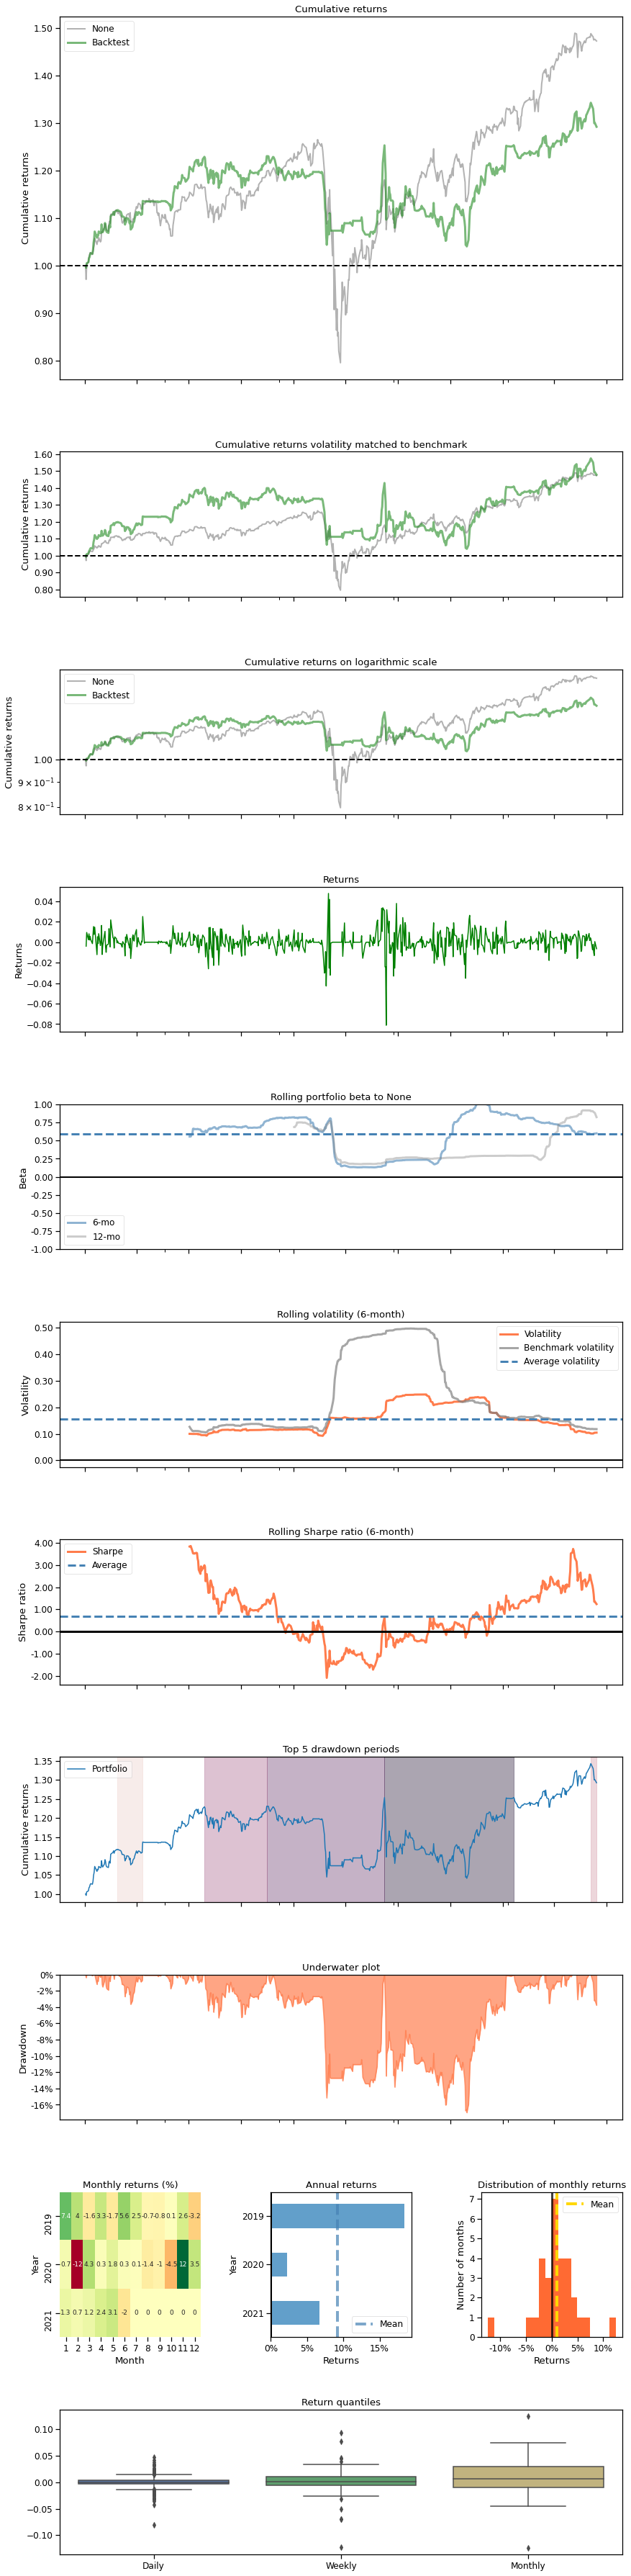

In [100]:
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                   benchmark_rets=dow_strat, set_context=False)

In [ ]:
'''
# Install the unstable development version in Jupyter notebook:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot
Data download

FinRL Use YahooDownloader Class to extract data .

Get full code , See the end of the article

class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)
Methods
    -------
    fetch_data()
        Fetches data from yahoo API
"""
Save the data ：

data_df = YahooDownloader(start_date = '2009-01-01', 
                          end_date = '2020-09-30', 
                          ticker_list = ['AAPL']).fetch_data()
view raw
Data preprocessing

Technical index construction ,inRL Use one FeatureEngineer Class to preprocess data .

Get full code , See the end of the article

class FeatureEngineer:
    """Provides methods for preprocessing the stock price data
Attributes
    ----------
        df: DataFrame
            data downloaded from Yahoo API
        feature_number : int
            number of features we used
        use_technical_indicator : boolean
            we technical indicator or not
        use_turbulence : boolean
            use turbulence index or not
Methods
    -------
    preprocess_data()
        main method to do the feature engineering
"""
Feature Engineering ：

data_df = FeatureEngineer(data_df.copy(),
                          use_technical_indicator=True,
                          tech_indicator_list = 
                          tech_indicator_list,use_turbulence=False,
                          user_defined_feature = True).preprocess_data()
Environment building

We define financial modeling as a Markov decision process （MDP） problem . The training process includes observing stock price changes , Take action and calculate the benefits , send agent Adjust its strategy . Through interaction with the environment , transaction agent Will get a trading strategy , as time goes on , Maximize revenue .

The trading environment is based on OpenAI Gym frame .

Environmental design is DRL One of the most important parts of , Because it will be different depending on the application and the market . We can't trade bitcoin in a stock trading environment , vice versa .

Operation space description allows agent Interact with the environment . Usually , action a There are three actions ：{- 1,0,1}, among - 1,0,1 It means sell 、 Hold and buy . meanwhile , One action can be performed on more than one share . We use an action space {-k,…,- 1,0,1,…,k}, among k Indicates the number of shares that need to be bought ,-k The number of shares that need to be sold . Continuous motion space needs to be normalized to [- 1,1], Because the strategy is defined on a Gaussian distribution , Normalization and symmetry are needed .

In this paper , We will k=200 Set to AAPL The entire operating space of is ：200*2+1=401.

FinRL Use EnvSetup Class to set the environment ：

Get full code , See the end of the article

class EnvSetup:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
Attributes
    ----------
    stock_dim: int
        number of unique stocks
    hmax : int
        maximum number of shares to trade
    initial_amount: int
        start money
    transaction_cost_pct : float
        transaction cost percentage per trade
    reward_scaling: float
        scaling factor for reward, good for training
    tech_indicator_list: list
        a list of technical indicator names (modified from config.py)
Methods
    -------
    fetch_data()
        Fetches data from yahoo API
"""
Initialize an environment class ：

env_setup = EnvSetup(stock_dim = stock_dimension,
                     state_space = state_space,
                     hmax = 200,
                     initial_amount = 100000,
                     transaction_cost_pct = 0.001,
                     tech_indicator_list = tech_indicator_list)
env_train = env_setup.create_env_training(data = train, 
                                         env_class = SingleStockEnv)
User defined rings ： Simulation environment class .

FinRL Provides a class for a single stock trading environment ：

Get full code , See the end of the article

class SingleStockEnv(gym.Env):
    """A single stock trading environment for OpenAI gym
    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date
    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next 
        observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
"""
Realization DRL Algorithm

DRL The implementation of the algorithm is based on OpenAI Baselines and Stable Baselines.Stable Baselines yes OpenAI Baselines A branch of the baseline , Including major structural refactoring and code cleaning .

FinRL Library fine tuned standards DRL Algorithm , Such as DQN、DDPG、Multi-Agent DDPG、PPO、SAC、A2C and TD3. It also allows users to adjust these DRL Algorithms to design their own DRL Algorithm ：

FinRL Use DRLAgent Class to implement the algorithm ：

class DRLAgent:
    """Provides implementations for DRL algorithms
Attributes
    ----------
    env: gym environment class
         user-defined class
Methods
    -------
    train_PPO()
        the implementation for PPO algorithm
    train_A2C()
        the implementation for A2C algorithm
    train_DDPG()
        the implementation for DDPG algorithm
    train_TD3()
        the implementation for TD3 algorithm 
    DRL_prediction() 
        make a prediction in a test dataset and get results
    """
model training

print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {'batch_size': 128,
                    'buffer_size':50000,
                    'learning_rate': 0.0001,
                    'verbose':0,
                    'timesteps':20000}
                    
agent = DRLAgent(env = env_train)

model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), 
                            model_params = td3_params_tuning)
In this article we used 4 Kind of DRL Model , namely PPO、A2C、DDPG and TD3.

TD3 yes DDPG An improvement of .

PPO：

A2C：
DDPG：

https://spinningup.openai.com/en/latest/algorithms/td3.html#background

Tensorboard：reward And loss function mapping
We use tensorboard integration Super parameter adjustment and model selection , The tension plate generates beautiful graphs .

Once called lear function , You can monitor during or after training RL agent, Use the following bash command ：

# cd to the tensorboard_log folder, run the following command 
tensorboard --logdir ./A2C_20201127-19h01/
# you can also add past logging folder
tensorboard --logdir ./a2c_tensorboard/;./ppo2_tensorboard/
The total of each algorithm is reward：

Total _ timesteps (int) : The total number of samples to train . It's one of the most important hyperparameters , There are other important parameters , Such as learning rate 、batch size、 buffer size etc. .

To compare these algorithms , I set total_timesteps = 100k. If we were to total_timesteps Set too large , So we're at risk of over fitting .

Through observation episode_reward Chart , We can see that as the steps grow , These algorithms will eventually converge to an optimal strategy .TD3 The convergence rate of is very fast .

actor_loss for DDPG and policy_loss for TD3：

We finally choose TD3 Model , Because it converges very quickly , And it's DDPG The most advanced model on . Through observation episode_reward Chart ,TD3 There is no need to reach 100k The total time of / The steps will converge .

transaction

Suppose we were 2019/01/01 Yes 10 Million dollars of initial capital , We use TD3 Models to trade AAPL.

env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                       env_class = SingleStockEnv)
## make a prediction and get the account value change
df_account_value = DRLAgent.DRL_prediction(model=model_td3,
                                           test_data = trade,
                                           test_env = env_trade,
                                           test_obs = obs_trade)
Back test performance

Use Quantopian pyfolio Test our trading strategy back and forth .

FinRL Use set of functions Yes pyfolio Carry out back testing .

Get full code , See the end of the article

print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value = df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')


# BackTestPlot
# pass the account value memory into the backtest functions
# and select a baseline ticker
print("=====Compare to AAPL itself buy-and-hold=======")
%matplotlib inline
BackTestPlot(account_value = df_account_value, 
             baseline_ticker = 'AAPL')


             '''
